In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
from environment import Environment
from generic_agent import GenericAgent
import gym
import random
import numpy as np
import torch
from torch import nn, optim
import matplotlib
from collections import deque, namedtuple, defaultdict

from matplotlib import pyplot as plt
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [3]:
env_name = "CartPole-v1"
env = Environment(env_name, render_mode="rgb_array")

Environment Name:  CartPole
Action Space Type:  DISCRETE
Observation Space Type:  CONTINUOUS
Observation Space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [4]:
# Device Utility

device = "cpu" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print("Device : ", device)

Device :  cpu


In [5]:
def plot_data(episode_duration, total_reward, show_result=False):
    f = plt.figure(figsize=(20, 10))
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    
    ax = plt.subplot(311)
    ax2 = plt.subplot(312)
    # ax3 = plt.subplot(313)
    ax.set_ylabel('Duration')
    # ax2.set_ylabel("Learning Rate")
    ax2.set_ylabel("Episode Reward")
    ax.plot(episode_duration )
    # ax2.plot(lr_data)
    ax2.plot(total_reward)
    
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)

In [6]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward", "terminate"))

class ReplayMemory:
    
    def __init__(self, capacity=10000):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    

In [7]:
BATCH_SIZE = 32
GAMMA = 0.97
TAU = 0.005

In [59]:
class FactorizedNoisyLayer(nn.Module):
    
    def __init__(self, in_feature, out_feature, is_training = True):
        super(FactorizedNoisyLayer, self).__init__()
        self.is_training = is_training
        self.in_feat = in_feature
        self.out_feat = out_feature
        # Slope 
        self.mu_weight = nn.Parameter(torch.FloatTensor(out_feature, in_feature))
        self.sigma_weight = nn.Parameter(torch.FloatTensor(out_feature, in_feature))
        
        # Bias
        self.mu_bias = nn.Parameter(torch.FloatTensor(out_feature))
        self.sigma_bias = nn.Parameter(torch.FloatTensor(out_feature))
        
        # Epsilon
        self.register_buffer("epsilon_i", torch.FloatTensor(in_feature))
        self.register_buffer("epsilon_j", torch.FloatTensor(out_feature))
        
        self.reset_parameters()
        self.reset_epsilon()
    
    def reset_parameters(self):
        std = 1 / np.sqrt(self.in_feat)
        
        self.mu_weight.data.uniform_(-std, std)
        self.mu_bias.data.uniform_(-std, std)

        self.sigma_weight.data.fill_(0.5 / np.sqrt(self.in_feat))
        self.sigma_bias.data.fill_(0.5 / np.sqrt(self.in_feat))

    
    def reset_epsilon(self):
        i = torch.randn(self.in_feat)
        j = torch.randn(self.out_feat)
        
        self.epsilon_i = torch.sign(i) * torch.sqrt(i.abs())
        self.epsilon_j = torch.sign(j) * torch.sqrt(j.abs())
    
    def forward(self, x):
        # import pdb; pdb.set_trace()
        self.reset_epsilon()
        
        if self.is_training:
            epsilon_weight = self.epsilon_j.ger(self.epsilon_i)
            epsilon_bias = self.epsilon_j
            weight = self.mu_weight + self.sigma_weight.mul(torch.autograd.Variable(epsilon_weight))
            bias = self.mu_bias + self.sigma_bias.mul(torch.autograd.Variable(epsilon_bias))
        else:
            weight = self.mu_weight
            bias = self.mu_bias
        
        return nn.functional.linear(x, weight, bias)
        

In [60]:
FactorizedNoisyLayer(3, 2)(torch.randn(3))

tensor([ 2.3895, -0.1825], grad_fn=<AddBackward0>)

In [61]:
class NoisyDQN(nn.Module):
    
    def __init__(self, in_feature, out_feature):
        super(NoisyDQN, self).__init__()
        self.feature_layer = nn.Sequential(
            nn.Linear(in_feature, 128),
            nn.ReLU(),
            FactorizedNoisyLayer(128, 128),
            nn.ReLU(),
            FactorizedNoisyLayer(128, out_feature)
        )
    def forward(self, observation):
        return self.feature_layer(observation)
        

In [62]:
class DoubleNoisyQNAgent(GenericAgent):
    
    def __init__(self, env):
        super(DoubleNoisyQNAgent, self).__init__(env)
        # Initializing the Models 
        self.dqn = NoisyDQN(self.observation_size[0], self.action_size).to(device)
        self.target_net = NoisyDQN(self.observation_size[0], self.action_size).to(device)
        self.target_net.load_state_dict(self.dqn.state_dict())
        
        
        self.optim = optim.AdamW(self.dqn.parameters(), amsgrad=True)
        self.criteria = nn.SmoothL1Loss()
        self.steps_done = 0
        self.discount_rate = GAMMA
        self.optimizer = optim.AdamW(self.dqn.parameters(), amsgrad=True)
    
    def get_action(self, observation):
        
        # Defining Exploration and exploration tradeoff
        EPS_START, EPS_END, EPS_DECAY = 0.05, 0.9, 1_000    
        threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1 * self.steps_done/EPS_DECAY)
        self.steps_done += 1
        
        if np.random.random() > threshold:
            action = self.get_random_action()
            return torch.tensor(action, dtype=torch.long)
        with torch.no_grad():
            obs = torch.tensor(observation, dtype=torch.float32).to(device)
            return self.dqn(obs).argmax()
    
    def train_model(self):
        
        if len(memory) < BATCH_SIZE:
            return None
        batch_data = memory.sample(BATCH_SIZE)
        # import pdb; pdb.set_trace()
        batches = Transition(*zip(*batch_data))
        
        # Preprocess records
        states = torch.stack(batches.state).to(device)
        actions = torch.tensor(batches.action).view(-1, 1).to(device)
        rewards = torch.tensor(batches.reward).view(-1, 1).to(device)

        # Train Execution
        pred_actions = self.dqn(states).gather(1, actions)
        
        # Non-Terminated States
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batches.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.stack([x for x in batches.next_state if x is not None])
    
        target_state_batch = torch.zeros(BATCH_SIZE)
        with torch.no_grad():
            target_state_batch[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        
        # target_state_with_done = (1 - torch.tensor(batches.terminate, dtype=torch.int)).view(-1, 1) * target_state_batch
        expected_state_action_values = (target_state_batch.view(-1, 1) * self.discount_rate) + rewards

        # Define Criteria 
        criteria = nn.SmoothL1Loss()
        loss = criteria(pred_actions, expected_state_action_values)

        # Optimization 
        self.optimizer.zero_grad()
        loss.backward()

        # Gradient Clipping
        nn.utils.clip_grad_norm(self.dqn.parameters(), 100)
        self.optimizer.step()
    


In [68]:
history = defaultdict(list)

In [63]:
memory = ReplayMemory()
history = defaultdict(list)

agent = DoubleNoisyQNAgent(env)

In [66]:
N_EPOCHS = 1000

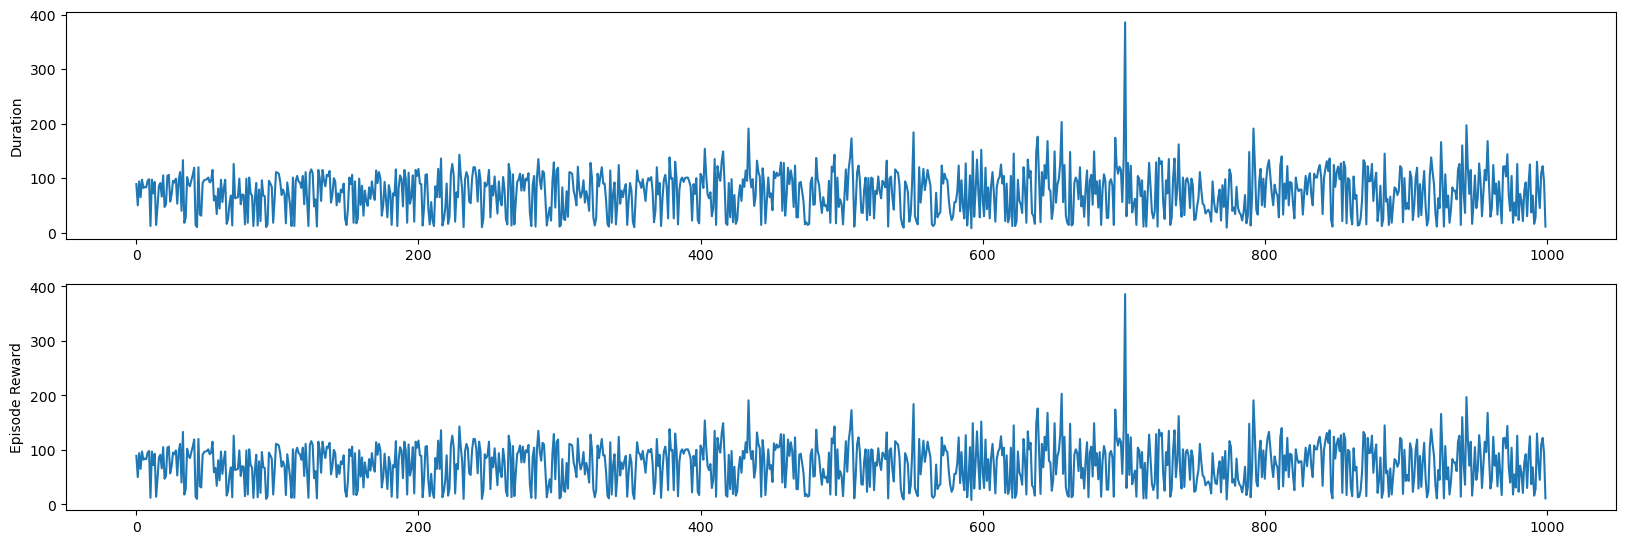

In [69]:
for epoch in range(N_EPOCHS):
    
    state, _ = env.reset()
    done = False
    total_reward, count = 0, 0
    state = torch.tensor(state)
    while not done:
        
        action = agent.get_action(state)
        
        next_state, reward, terminate, trunc, info = env.step(action.item())
        
        count += 1
        total_reward += reward
        
        done = terminate or trunc
        next_state = None if terminate else torch.tensor(next_state)
        reward = torch.tensor(reward, dtype=torch.float32)
        
        memory.push(state, action, next_state, reward, terminate)
        state = next_state
        
        # Training the model
        agent.train_model()
        
    # updating weights for target net using TAU after every episode
    target_net_state_dict = agent.target_net.state_dict()
    dqn_net_state_dict = agent.dqn.state_dict()
    for key, value in target_net_state_dict.items():
        target_net_state_dict[key] = TAU * dqn_net_state_dict[key] + (1 - TAU) * value

    agent.target_net.load_state_dict(target_net_state_dict)
    
    
    history["episode_duration"].append(count)
    history["rewards"].append(total_reward)
    plot_data(history["episode_duration"], history["rewards"])

In [70]:
env.close()